# Standard Imports

In [10]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
from matplotlib import pylab
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import CPTAC.Endometrial as CPTAC

In [11]:
def find_pvals(merged_df, bf, sig):
    pvals_dict = {}
    pvals_dict, All_Sig = perform_ttest('All', pvals_dict, merged_df, bf, sig)
    pvals_dict, Hotspot_Sig = perform_ttest('Hotspot', pvals_dict, merged_df, bf, sig)
    pvals_dict, Non_Hotspot_Sig = perform_ttest('Non_Hotspot', pvals_dict, merged_df, bf, sig)
    
    if All_Sig == True or Hotspot_Sig == True or Non_Hotspot_Sig == True:
        sig = True
        
    return pvals_dict, sig

In [12]:
# Function to return a dictionary of mutation comparison pvalues from different data locations
# parameters of function are perform_ttest(what kind of mutation comparison, dictionary to append, dataframe, and p-cutoff)
def perform_ttest(comp_type, pvals_dict, merged_df, bf, sig):
    if comp_type == 'All':
        # Finding pvalues for the transcriptome
        t_mut = merged_df.loc[merged_df['Mutation_Type'] != 'Wildtype', 'Transcriptome']
        t_wt = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Transcriptome']
        t_tt = scipy.stats.ttest_ind(t_wt, t_mut)
        pvals_dict[comp_type + '_Txn_pval'] = t_tt[1]
        pvals_dict[comp_type + '_Txn_pval_-Log10'] = np.log10(t_tt[1])*-1
        # Finding pvalues for the proteome
        p_mut = merged_df.loc[merged_df['Mutation_Type'] != 'Wildtype', 'Proteome']
        p_wt = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Proteome']
        p_tt = scipy.stats.ttest_ind(p_wt, p_mut)
        pvals_dict[comp_type + '_Prot_pval'] = p_tt[1]
        pvals_dict[comp_type + '_Prot_pval_-Log10'] = np.log10(p_tt[1])*-1
        # Finding the mean difference for the transcriptome
        t_mut_mean = merged_df.loc[merged_df['Mutation_Type'] != 'Wildtype', 'Transcriptome'].mean()
        t_wt_mean = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Transcriptome'].mean()
        t_dif = t_wt_mean - t_mut_mean
        pvals_dict[comp_type + '_Txn_Mean_Dif'] = t_dif
        # Finding the mean difference for the proteome
        p_mut_mean = merged_df.loc[merged_df['Mutation_Type'] != 'Wildtype', 'Proteome'].mean()
        p_wt_mean = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Proteome'].mean()
        p_dif = p_wt_mean - p_mut_mean
        pvals_dict[comp_type + '_Prot_Mean_Dif'] = p_dif
        
    else:
        # Finding the pvalues for the transcriptome
        t_mut = merged_df.loc[merged_df['Mutation_Type'] == comp_type, 'Transcriptome']
        t_wt = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Transcriptome']
        t_tt = scipy.stats.ttest_ind(t_wt, t_mut)
        pvals_dict[comp_type + '_Txn_pval'] = t_tt[1]
        pvals_dict[comp_type + '_Txn_pval_-Log10'] = np.log10(t_tt[1])*-1
        # Finding pvalues for the proteome
        p_mut = merged_df.loc[merged_df['Mutation_Type'] == comp_type, 'Proteome']
        p_wt = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Proteome']
        p_tt = scipy.stats.ttest_ind(p_wt, p_mut)
        pvals_dict[comp_type + '_Prot_pval'] = p_tt[1]
        pvals_dict[comp_type + '_Prot_pval_-Log10'] = np.log10(p_tt[1])*-1
        # Finding the mean difference for the transcriptome
        t_mut_mean = merged_df.loc[merged_df['Mutation_Type'] == comp_type, 'Transcriptome'].mean()
        t_wt_mean = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Transcriptome'].mean()
        t_dif = t_wt_mean - t_mut_mean
        pvals_dict[comp_type + '_Txn_Mean_Dif'] = t_dif
        # Finding the mean difference for the proteome
        p_mut_mean = merged_df.loc[merged_df['Mutation_Type'] == comp_type, 'Proteome'].mean()
        p_wt_mean = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Proteome'].mean()
        p_dif = p_wt_mean - p_mut_mean
        pvals_dict[comp_type + '_Prot_Mean_Dif'] = p_dif
        
    if t_tt[1] <= bf and p_tt[1] <= bf:
        pvals_dict[comp_type + '_Sig_In'] = 'Both'
        sig = True
    elif t_tt[1] <= bf and p_tt[1] > bf:
        pvals_dict[comp_type + '_Sig_In'] = 'Transcriptome'
        sig = True
    elif t_tt[1] > bf and p_tt[1] <= bf:
        pvals_dict[comp_type + '_Sig_In'] = 'Proteome'
        sig = True
    else:
        pvals_dict[comp_type + '_Sig_In'] = 'Neither'

    return pvals_dict, sig

In [45]:
def get_plot_comp(comp_type, data_type, df):
    px = df.loc[df[comp_type + '_Sig_In'] == 'Proteome', comp_type + '_Txn_' + data_type]
    py = df.loc[df[comp_type + '_Sig_In'] == 'Proteome', comp_type + '_Prot_' + data_type]
    p_unique = (px, py)

    tx = df.loc[df[comp_type + '_Sig_In'] == 'Transcriptome', comp_type + '_Txn_' + data_type]
    ty = df.loc[df[comp_type + '_Sig_In'] == 'Transcriptome', comp_type + '_Prot_' + data_type]
    t_unique = (tx, ty)

    sx = df.loc[df[comp_type + '_Sig_In'] == 'Both', comp_type + '_Txn_' + data_type]
    sy = df.loc[df[comp_type + '_Sig_In'] == 'Both', comp_type + '_Prot_' + data_type]
    shared = (sx, sy)
    
    data = (p_unique, t_unique, shared)

    return data
        

In [46]:
def get_plot_data(where_sig, data_type, df):
        
    px = df.loc[df['All_Sig_In'] == where_sig, 'All_Txn_' + data_type]
    py = df.loc[df['All_Sig_In'] == where_sig, 'All_Prot_' + data_type]
    p_unique = (px, py)

    tx = df.loc[df['Hotspot_Sig_In'] == where_sig, 'Hotspot_Txn_' + data_type]
    ty = df.loc[df['Hotspot_Sig_In'] == where_sig, 'Hotspot_Prot_' + data_type]
    t_unique = (tx, ty)

    sx = df.loc[df['Non_Hotspot_Sig_In'] == where_sig, 'Non_Hotspot_Txn_' + data_type]
    sy = df.loc[df['Non_Hotspot_Sig_In'] == where_sig, 'Non_Hotspot_Prot_' + data_type]
    shared = (sx, sy)
    
    data = (p_unique, t_unique, shared)

    return data

### Designating CPTAC Variables

In [15]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
transcriptomics = CPTAC.get_transcriptomics()

### Designating a List of TP53 Hotspot Mutations Found in a Previous Analysis

In [16]:
# A list of mutations present in the hotspot according to our Hotspot3D output
gene = 'TP53'
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.241del','p.K164E', 'p.R249S', 'p.R273H', 'p.R282W','p.S127Y', 'p.G244D', 'p.A159P']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

In [17]:
shared_protein_list = list()
for protein in proteomics.columns:
    if protein in transcriptomics.columns:
        shared_protein_list.append(protein)

In [18]:
pcutoff = 0.05/len(shared_protein_list)
print('Our bonferroni p-cutoff value is ' + str(pcutoff))

Our bonferroni p-cutoff value is 4.551247041689423e-06


In [20]:
all_data = pd.DataFrame({'Protein': shared_protein_list})
for protein in shared_protein_list:
    sig = False
    proteomics_df = CPTAC.compare_mutations(proteomics, protein, gene)
    proteomics_df.columns = ['Proteome', 'Mutation', 'Sample_Status']
    transcriptomics_df = CPTAC.compare_mutations(transcriptomics, protein, gene)
    transcriptomics_df.columns = ['Transcriptome', 'Mutation', 'Sample_Status']
    merged_data = proteomics_df.join(transcriptomics_df['Transcriptome'])
    merged_data.loc[merged_data['Sample_Status'] == 'Tumor', 'Mutation_Type'] = 'Non_Hotspot'
    merged_data.loc[hotspot_patients, 'Mutation_Type'] = 'Hotspot'
    merged_data.loc[merged_data['Mutation'] == 'Wildtype_Tumor', 'Mutation_Type'] = 'Wildtype'
    merged_data = merged_data.loc[merged_data['Sample_Status'] == 'Tumor'].dropna(axis=0)
    pvals_dict, sig = find_pvals(merged_data, pcutoff, sig)
    if sig == True:
        for key in pvals_dict:
            all_data.loc[all_data['Protein'] == protein, key] = pvals_dict[key]

In [21]:
all_data = all_data.dropna(axis = 0)

## All TP53 Mutations vs Wildtype Analysis

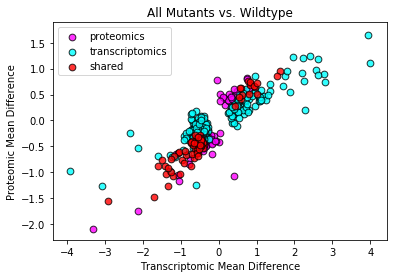

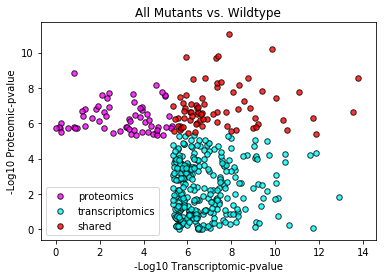

In [62]:
data = get_plot_comp('All', 'Mean_Dif', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('proteomics', 'transcriptomics', 'shared')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=45, label=group)
    
plt.title('All Mutants vs. Wildtype')
plt.legend(loc=2)
plt.xlabel("Transcriptomic Mean Difference")
plt.ylabel("Proteomic Mean Difference")
plt.show()

data = get_plot_comp('All', 'pval_-Log10', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('proteomics', 'transcriptomics', 'shared')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('All Mutants vs. Wildtype')
plt.legend(loc=3)
plt.xlabel("-Log10 Transcriptomic-pvalue")
plt.ylabel("-Log10 Proteomic-pvalue")
plt.show()

## Hotspot TP53 Mutations vs Wildtype Analysis

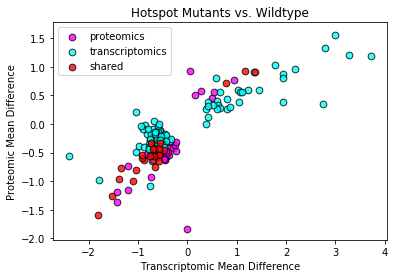

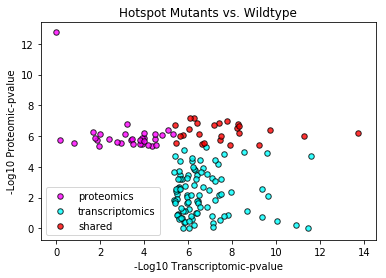

In [63]:
data = get_plot_comp('Hotspot', 'Mean_Dif', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('proteomics', 'transcriptomics', 'shared')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=45, label=group)
    
plt.title('Hotspot Mutants vs. Wildtype')
plt.legend(loc=2)
plt.xlabel("Transcriptomic Mean Difference")
plt.ylabel("Proteomic Mean Difference")
plt.show()

data = get_plot_comp('Hotspot', 'pval_-Log10', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('proteomics', 'transcriptomics', 'shared')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Hotspot Mutants vs. Wildtype')
plt.legend(loc=3)
plt.xlabel("-Log10 Transcriptomic-pvalue")
plt.ylabel("-Log10 Proteomic-pvalue")
plt.show()

## Non-Hotspot TP53 Mutations vs Wildtype Analysis

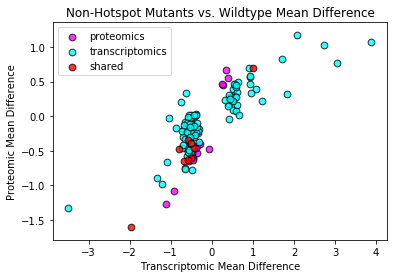

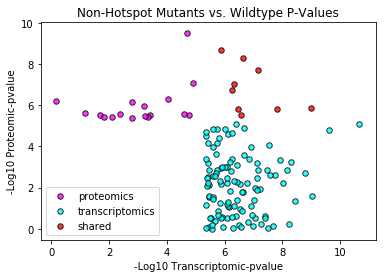

In [65]:
data = get_plot_comp('Non_Hotspot', 'Mean_Dif', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('proteomics', 'transcriptomics', 'shared')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=45, label=group)
    
plt.title('Non-Hotspot Mutants vs. Wildtype Mean Difference')
plt.legend(loc=2)
plt.xlabel("Transcriptomic Mean Difference")
plt.ylabel("Proteomic Mean Difference")
plt.show()

data = get_plot_comp('Non_Hotspot', 'pval_-Log10', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('proteomics', 'transcriptomics', 'shared')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Non-Hotspot Mutants vs. Wildtype P-Values')
plt.legend(loc=3)
plt.xlabel("-Log10 Transcriptomic-pvalue")
plt.ylabel("-Log10 Proteomic-pvalue")
plt.show()

### Graphing the same sets of data from each of the different comparison groups

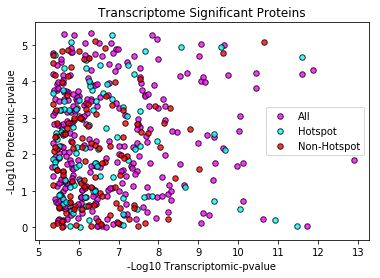

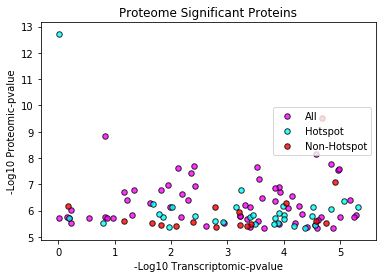

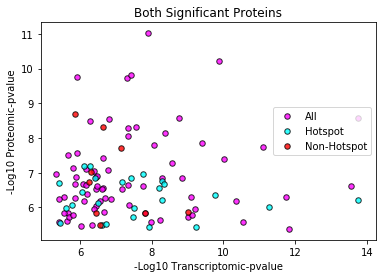

In [61]:
data = get_plot_data('Transcriptome', 'pval_-Log10', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('All', 'Hotspot', 'Non-Hotspot')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Transcriptome Significant Proteins')
plt.legend(loc=5)
plt.xlabel("-Log10 Transcriptomic-pvalue")
plt.ylabel("-Log10 Proteomic-pvalue")
plt.show()

data = get_plot_data('Proteome', 'pval_-Log10', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('All', 'Hotspot', 'Non-Hotspot')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Proteome Significant Proteins')
plt.legend(loc=5)
plt.xlabel("-Log10 Transcriptomic-pvalue")
plt.ylabel("-Log10 Proteomic-pvalue")
plt.show()

data = get_plot_data('Both', 'pval_-Log10', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('All', 'Hotspot', 'Non-Hotspot')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Both Significant Proteins')
plt.legend(loc=5)
plt.xlabel("-Log10 Transcriptomic-pvalue")
plt.ylabel("-Log10 Proteomic-pvalue")
plt.show()

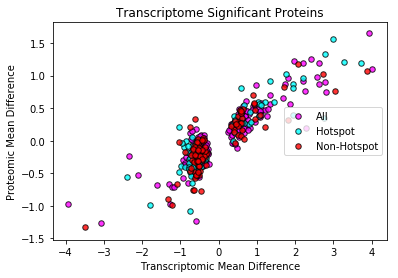

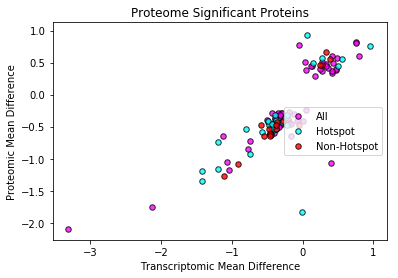

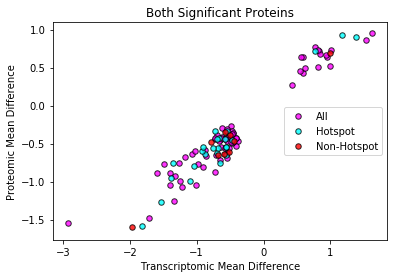

In [60]:
data = get_plot_data('Transcriptome', 'Mean_Dif', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('All', 'Hotspot', 'Non-Hotspot')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Transcriptome Significant Proteins')
plt.legend(loc=5)
plt.xlabel("Transcriptomic Mean Difference")
plt.ylabel("Proteomic Mean Difference")
plt.show()

data = get_plot_data('Proteome', 'Mean_Dif', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('All', 'Hotspot', 'Non-Hotspot')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Proteome Significant Proteins')
plt.legend(loc=5)
plt.xlabel("Transcriptomic Mean Difference")
plt.ylabel("Proteomic Mean Difference")
plt.show()

data = get_plot_data('Both', 'Mean_Dif', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('All', 'Hotspot', 'Non-Hotspot')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Both Significant Proteins')
plt.legend(loc=5)
plt.xlabel("Transcriptomic Mean Difference")
plt.ylabel("Proteomic Mean Difference")
plt.show()